# Séance 3: TP1 - Pipeline de Classification Binaire


## Informations de la séance
- **Type**: Travaux Pratiques
- **Durée**: 2h
- **Objectifs**: Obj6, Obj7
- **Dataset**: Titanic (prédiction de survie)


## Objectifs du TP

À la fin de ce TP, vous serez capable de:

1. Charger et explorer un dataset
2. Préparer les données pour l'apprentissage
3. Créer un pipeline de prétraitement avec Scikit-learn
4. Entraîner un modèle de classification binaire
5. Évaluer les performances du modèle

## 1. Configuration de l'Environnement

In [34]:
# Installation des bibliothèques (si nécessaire)
# !pip install scikit-learn pandas numpy matplotlib seaborn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Configuration
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("✓ Bibliothèques importées avec succès")

✓ Bibliothèques importées avec succès


## 2. Chargement et Exploration des Données

### 2.1 Chargement du Dataset Titanic

In [35]:
# Chargement depuis seaborn
titanic = sns.load_dataset('titanic')

# Affichage des premières lignes
print("Aperçu des données:")
print(titanic.head())

print(f"\nDimensions: {titanic.shape}")
print(f"Colonnes: {titanic.columns.tolist()}")

Aperçu des données:
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  

Dimensions: (891, 15)
Colonnes: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


### 2.2 Exploration Initiale

In [36]:
# Informations générales
print("Informations sur le dataset:")
print(titanic.info())

print("\nStatistiques descriptives:")
print(titanic.describe())

# Vérification des valeurs manquantes
print("\nValeurs manquantes:")
print(titanic.isnull().sum())

# Distribution de la variable cible
print("\nDistribution de la survie:")
print(titanic['survived'].value_counts())
print(f"\nTaux de survie: {titanic['survived'].mean():.2%}")

Informations sur le dataset:
<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    str     
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    str     
 8   class        891 non-null    category
 9   who          891 non-null    str     
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    str     
 13  alive        891 non-null    str     
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), str(5)
memory usage: 80.7 KB
None

Statistiques descriptives:
         survived      pclass   

### 2.3 Visualisations Exploratoires

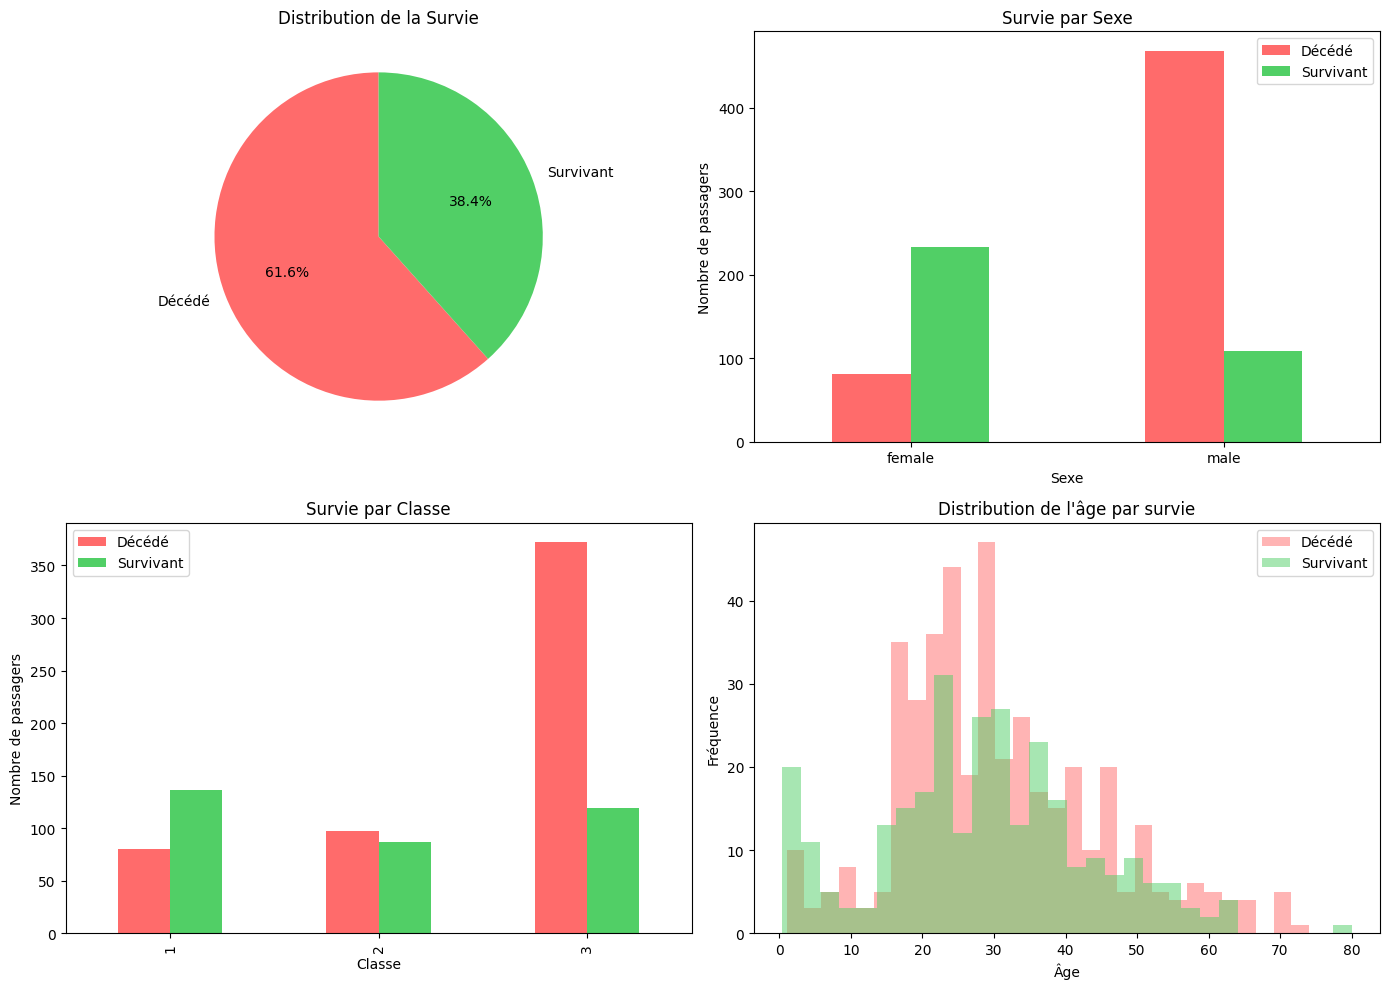

In [37]:
# Figure 1: Distribution de la survie
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Survie globale
axes[0, 0].pie(
    titanic['survived'].value_counts(), 
    labels=['Décédé', 'Survivant'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff6b6b', '#51cf66']
)
axes[0, 0].set_title('Distribution de la Survie')

# Survie par sexe
survival_by_sex = titanic.groupby(['sex', 'survived']).size().unstack()
survival_by_sex.plot(kind='bar', ax=axes[0, 1], color=['#ff6b6b', '#51cf66'])
axes[0, 1].set_title('Survie par Sexe')
axes[0, 1].set_xlabel('Sexe')
axes[0, 1].set_ylabel('Nombre de passagers')
axes[0, 1].legend(['Décédé', 'Survivant'])
axes[0, 1].tick_params(axis='x', rotation=0)

# Survie par classe
survival_by_class = titanic.groupby(['pclass', 'survived']).size().unstack()
survival_by_class.plot(kind='bar', ax=axes[1, 0], color=['#ff6b6b', '#51cf66'])
axes[1, 0].set_title('Survie par Classe')
axes[1, 0].set_xlabel('Classe')
axes[1, 0].set_ylabel('Nombre de passagers')
axes[1, 0].legend(['Décédé', 'Survivant'])

# Distribution de l'âge
axes[1, 1].hist(titanic[titanic['survived']==0]['age'].dropna(), 
                alpha=0.5, label='Décédé', bins=30, color='#ff6b6b')
axes[1, 1].hist(titanic[titanic['survived']==1]['age'].dropna(), 
                alpha=0.5, label='Survivant', bins=30, color='#51cf66')
axes[1, 1].set_title("Distribution de l'âge par survie")
axes[1, 1].set_xlabel('Âge')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 3. Préparation des Données

### 3.1 Sélection des Features

In [38]:
# Sélection des colonnes pertinentes
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'

# Création du dataset de travail
df = titanic[features + [target]].copy()

print(f"Dataset de travail: {df.shape}")
print(f"\nValeurs manquantes:")
print(df.isnull().sum())

Dataset de travail: (891, 8)

Valeurs manquantes:
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
survived      0
dtype: int64


### 3.2 Traitement des Valeurs Manquantes

In [40]:
# Stratégies de traitement
# 1. Age: remplir avec la médiane
df['age'] = df['age'].fillna(df['age'].median())

# 2. Embarked: remplir avec le mode (valeur la plus fréquente)
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

# 3. Fare: remplir avec la médiane (si manquant)
df['fare'] = df['fare'].fillna(df['fare'].median())

# Vérification
print("Après traitement:")
print(df.isnull().sum())

Après traitement:
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
survived    0
dtype: int64


### 3.3 Encodage des Variables Catégorielles

In [41]:
# Encodage de 'sex'
df['sex'] = df['sex'].map({'male': 0, 'female': 1})

# Encodage de 'embarked' (One-Hot Encoding)
df = pd.get_dummies(df, columns=['embarked'], prefix='embarked', drop_first=True)

print("Dataset après encodage:")
print(df.head())
print(f"\nNouvelles dimensions: {df.shape}")

Dataset après encodage:
   pclass  sex   age  sibsp  parch     fare  survived  embarked_Q  embarked_S
0       3    0  22.0      1      0   7.2500         0       False        True
1       1    1  38.0      1      0  71.2833         1       False       False
2       3    1  26.0      0      0   7.9250         1       False        True
3       1    1  35.0      1      0  53.1000         1       False        True
4       3    0  35.0      0      0   8.0500         0       False        True

Nouvelles dimensions: (891, 9)


### 3.4 Séparation Features / Target

In [42]:
# Séparation X (features) et y (target)
X = df.drop('survived', axis=1)
y = df['survived']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeatures utilisées:\n{X.columns.tolist()}")

X shape: (891, 8)
y shape: (891,)

Features utilisées:
['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked_Q', 'embarked_S']


## 4. Split Train/Validation/Test

### 4.1 Split Train/Test

In [43]:
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% pour le test
    random_state=42,    # reproductibilité
    stratify=y          # préserver la distribution des classes
)

print(f"Train set: {X_train.shape}")
print(f"Test set:  {X_test.shape}")

# Vérification de la distribution
print(f"\nDistribution train: {y_train.value_counts(normalize=True)}")
print(f"Distribution test:  {y_test.value_counts(normalize=True)}")

Train set: (712, 8)
Test set:  (179, 8)

Distribution train: survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64
Distribution test:  survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


### 4.2 Split Train/Validation (optionnel)

In [44]:
# Optionnel: créer un ensemble de validation
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 20% du train pour validation
    random_state=42,
    stratify=y_train
)

print(f"Train full: {X_train_full.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_test.shape}")

Train full: (569, 8)
Validation: (143, 8)
Test:       (179, 8)


## 5. Pipeline de Prétraitement et Entraînement

### 5.1 Création du Pipeline

In [45]:
# Pipeline: Standardisation + Modèle
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Étape 1: Standardisation
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Étape 2: Modèle
])

print("Pipeline créé:")
print(pipeline)

Pipeline créé:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])


### 5.2 Entraînement du Modèle

In [46]:
# Entraînement
print("Entraînement en cours...")
pipeline.fit(X_train, y_train)
print("✓ Entraînement terminé")

# Prédictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print("✓ Prédictions effectuées")

Entraînement en cours...
✓ Entraînement terminé
✓ Prédictions effectuées


## 6. Évaluation Initiale

### 6.1 Accuracy

In [47]:
# Calcul de l'accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy Train: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Accuracy Test:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Analyse de l'overfitting
diff = train_accuracy - test_accuracy
print(f"\nDifférence Train-Test: {diff:.4f}")
if diff < 0.05:
    print("→ Bon équilibre biais-variance")
elif diff < 0.10:
    print("→ Léger overfitting")
else:
    print("→ Overfitting significatif")

Accuracy Train: 0.8076 (80.76%)
Accuracy Test:  0.8045 (80.45%)

Différence Train-Test: 0.0031
→ Bon équilibre biais-variance


### 6.2 Matrice de Confusion

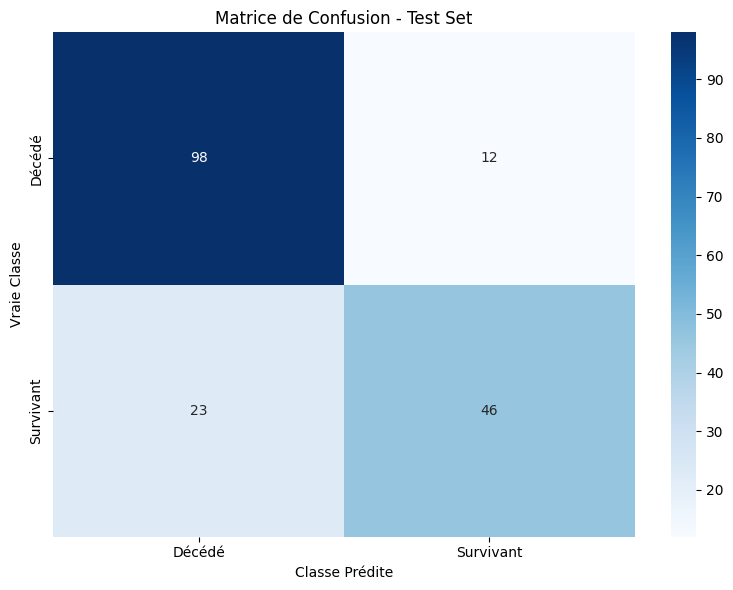


Vrais Négatifs (TN):  98
Faux Positifs (FP):   12
Faux Négatifs (FN):   23
Vrais Positifs (TP):  46


In [48]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

# Visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Décédé', 'Survivant'],
            yticklabels=['Décédé', 'Survivant'])
plt.title('Matrice de Confusion - Test Set')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.tight_layout()
plt.show()

# Interprétation
tn, fp, fn, tp = cm.ravel()
print(f"\nVrais Négatifs (TN):  {tn}")
print(f"Faux Positifs (FP):   {fp}")
print(f"Faux Négatifs (FN):   {fn}")
print(f"Vrais Positifs (TP):  {tp}")

### 6.3 Rapport de Classification

In [49]:
# Rapport détaillé
print("\nRapport de Classification:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Décédé', 'Survivant']))


Rapport de Classification:
              precision    recall  f1-score   support

      Décédé       0.81      0.89      0.85       110
   Survivant       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



## 7. Comparaison de Plusieurs Modèles


Logistic Regression:
  Train Accuracy: 0.8076
  Test Accuracy:  0.8045
  Différence:     0.0031

Decision Tree:
  Train Accuracy: 0.8652
  Test Accuracy:  0.7765
  Différence:     0.0886

Random Forest:
  Train Accuracy: 0.8652
  Test Accuracy:  0.7933
  Différence:     0.0719


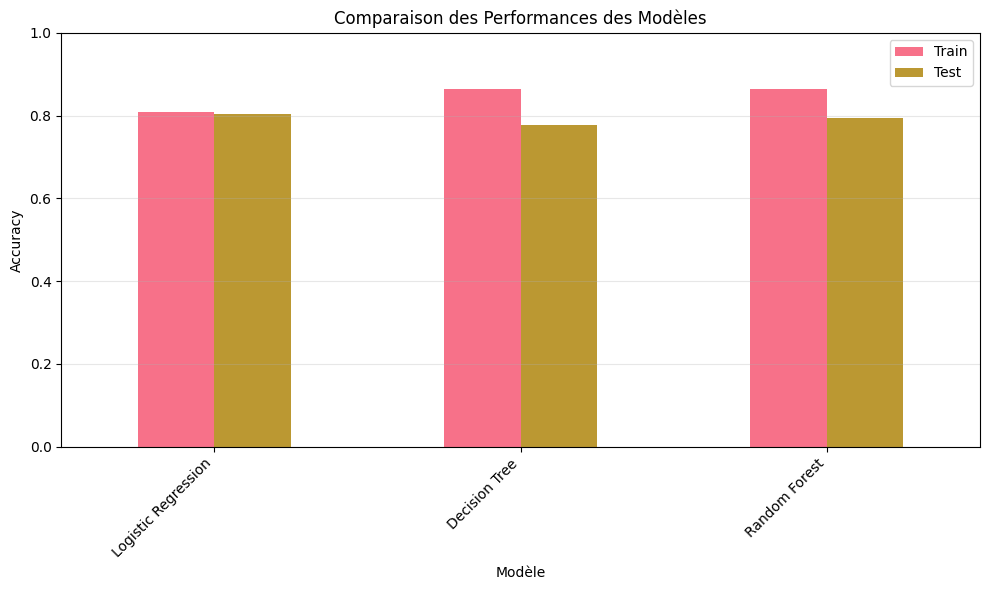

In [50]:
# Définition des modèles
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Entraînement et évaluation
results = {}
for name, model in models.items():
    # Pipeline pour chaque modèle
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Entraînement
    pipe.fit(X_train, y_train)
    
    # Évaluation
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    
    results[name] = {
        'train': train_score,
        'test': test_score,
        'diff': train_score - test_score
    }
    
    print(f"\n{name}:")
    print(f"  Train Accuracy: {train_score:.4f}")
    print(f"  Test Accuracy:  {test_score:.4f}")
    print(f"  Différence:     {train_score - test_score:.4f}")

# Visualisation comparative
df_results = pd.DataFrame(results).T
df_results[['train', 'test']].plot(kind='bar', figsize=(10, 6))
plt.title('Comparaison des Performances des Modèles')
plt.xlabel('Modèle')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Analyse des Prédictions

### 8.1 Exemples de Prédictions

In [51]:
# Prédictions avec probabilités
y_proba = pipeline.predict_proba(X_test)

# Affichage de quelques exemples
n_samples = 5
indices = np.random.choice(len(X_test), n_samples, replace=False)

print("Exemples de prédictions:\n")
for idx in indices:
    actual = y_test.iloc[idx]
    predicted = y_test_pred[idx]
    proba = y_proba[idx]
    
    print(f"Passager {idx}:")
    print(f"  Vraie classe:     {'Survivant' if actual == 1 else 'Décédé'}")
    print(f"  Prédiction:       {'Survivant' if predicted == 1 else 'Décédé'}")
    print(f"  Probabilités:     Décédé={proba[0]:.2%}, Survivant={proba[1]:.2%}")
    print(f"  Correct:          {'+' if actual == predicted else '+'}")
    print()

Exemples de prédictions:

Passager 78:
  Vraie classe:     Décédé
  Prédiction:       Décédé
  Probabilités:     Décédé=84.56%, Survivant=15.44%
  Correct:          +

Passager 16:
  Vraie classe:     Décédé
  Prédiction:       Décédé
  Probabilités:     Décédé=61.60%, Survivant=38.40%
  Correct:          +

Passager 65:
  Vraie classe:     Décédé
  Prédiction:       Survivant
  Probabilités:     Décédé=44.38%, Survivant=55.62%
  Correct:          +

Passager 114:
  Vraie classe:     Survivant
  Prédiction:       Survivant
  Probabilités:     Décédé=23.62%, Survivant=76.38%
  Correct:          +

Passager 76:
  Vraie classe:     Décédé
  Prédiction:       Décédé
  Probabilités:     Décédé=93.14%, Survivant=6.86%
  Correct:          +



### 8.2 Analyse des Erreurs

In [52]:
# Identification des erreurs
errors = X_test[y_test != y_test_pred].copy()
errors['actual'] = y_test[y_test != y_test_pred]
errors['predicted'] = y_test_pred[y_test != y_test_pred]

print(f"Nombre d'erreurs: {len(errors)}")
print(f"Taux d'erreur: {len(errors)/len(X_test):.2%}")

print("\nQuelques erreurs:")
print(errors.head())

# Analyse des caractéristiques des erreurs
print("\nCaractéristiques moyennes des erreurs vs correctes:")
correct = X_test[y_test == y_test_pred]

comparison = pd.DataFrame({
    'Erreurs': errors.drop(['actual', 'predicted'], axis=1).mean(),
    'Correctes': correct.mean()
})
print(comparison)

Nombre d'erreurs: 35
Taux d'erreur: 19.55%

Quelques erreurs:
     pclass  sex   age  sibsp  parch     fare  embarked_Q  embarked_S  actual  \
553       3    0  22.0      0      0   7.2250       False       False       1   
559       3    1  36.0      1      0  17.4000       False        True       1   
279       3    1  35.0      1      1  20.2500       False        True       1   
712       1    0  48.0      1      0  52.0000       False        True       1   
455       3    0  29.0      0      0   7.8958       False       False       1   

     predicted  
553          0  
559          0  
279          0  
712          0  
455          0  

Caractéristiques moyennes des erreurs vs correctes:
              Erreurs  Correctes
pclass       2.257143   2.319444
sex          0.342857   0.340278
age         26.742857  29.512153
sibsp        0.457143   0.687500
parch        0.400000   0.333333
fare        24.618686  35.948465
embarked_Q   0.085714   0.131944
embarked_S   0.714286   0.715278

## Exercices Pratiques

### Exercice 1: Feature Engineering

Créez une nouvelle feature `family_size` = `sibsp` + `parch` + 1, puis ré-entraînez le modèle. La performance s'améliore-t-elle ?

#### Solution

In [53]:
# Création de la nouvelle feature
df['family_size'] = df['sibsp'] + df['parch'] + 1

# Refaire le split et l'entraînement
X_new = df.drop('survived', axis=1)
y_new = df['survived']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.2, random_state=42, stratify=y_new
)

pipeline_new = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_new.fit(X_train_new, y_train_new)
new_score = pipeline_new.score(X_test_new, y_test_new)

print(f"Accuracy avec family_size: {new_score:.4f}")
print(f"Accuracy sans family_size: {test_accuracy:.4f}")
print(f"Amélioration: {new_score - test_accuracy:.4f}")

Accuracy avec family_size: 0.8045
Accuracy sans family_size: 0.8045
Amélioration: 0.0000


### Exercice 2: Optimisation des Hyperparamètres

Testez différentes valeurs de `max_depth` pour le Decision Tree (3, 5, 7, 10, None). Quelle valeur donne les meilleures performances sur le test set ?

#### Solution


Résultats pour différentes profondeurs:
              max_depth     train      test      diff
0                     3  0.832865  0.793296  0.039569
1                     5  0.865169  0.776536  0.088632
2                     7  0.890449  0.810056  0.080394
3                    10  0.942416  0.798883  0.143533
4  None (pas de limite)  0.981742  0.821229  0.160513

Meilleur max_depth (sans None): 7
Test Accuracy: 0.8101
Train Accuracy: 0.8904
Différence Train-Test: 0.0804


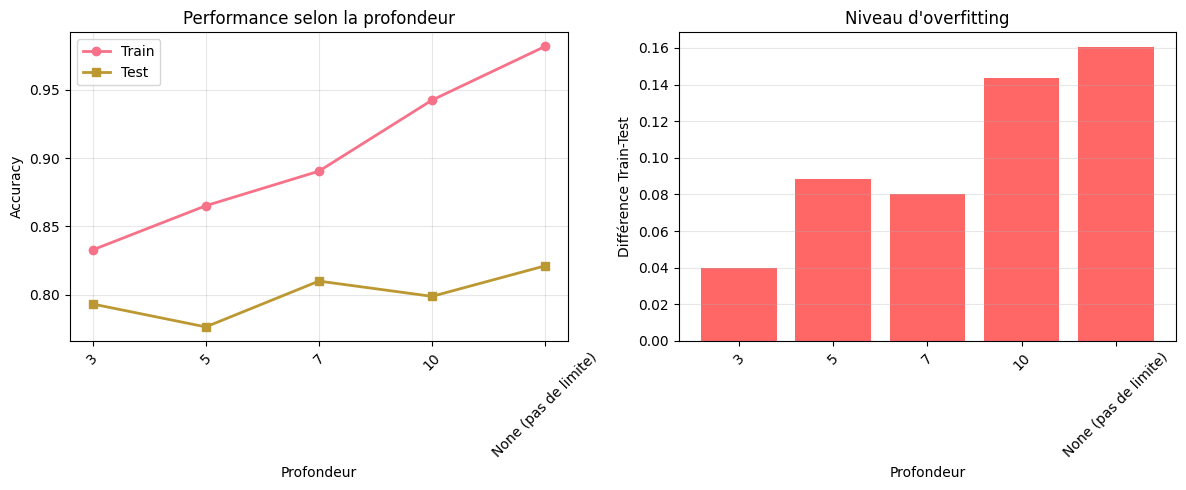


=== ANALYSE DÉTAILLÉE ===

1. max_depth = 3:
   - Test: 0.7933, Train: 0.8329
   - Modèle simple, peu d'overfitting mais peut être sous-optimal

2. max_depth = 5:
   - Test: 0.7765, Train: 0.8652
   - Bon compromis entre biais et variance

3. max_depth = 7 ou 10:
   - Test: 0.8101 et 0.7989
   - Performance légèrement meilleure mais risque d'overfitting accru

4. max_depth = None (pas de limite):
   - Test: 0.8212, Train: 0.9817
   - Différence: 0.1605
   - FORT RISQUE D'OVERFITTING sur de nouvelles données
   - Le modèle mémorise le bruit des données d'entraînement

=== RECOMMANDATION ===
Le meilleur choix est max_depth = 7 car:
1. Il maximise le score sur le test set parmi les valeurs raisonnables
2. La différence Train-Test est acceptable (équilibre biais-variance)
3. Le modèle reste interprétable (arbre de taille raisonnable)

Validation croisée (5 folds) pour max_depth = 7:
  Scores: [0.76223776 0.7972028  0.83098592 0.85915493 0.83098592]
  Moyenne: 0.8161 (+/- 0.0667)


In [54]:
depths = [3, 5, 7, 10, None]
results_depth = []

for depth in depths:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(max_depth=depth, random_state=42))
    ])
    
    pipe.fit(X_train, y_train)
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    
    results_depth.append({
        'max_depth': str(depth) if depth is not None else 'None (pas de limite)',
        'train': train_score,
        'test': test_score,
        'diff': train_score - test_score
    })
    
df_depth = pd.DataFrame(results_depth)
print("\nRésultats pour différentes profondeurs:")
print(df_depth)

# CORRECTION 1: Exclure None de la recherche du meilleur modèle
df_without_none = df_depth[df_depth['max_depth'] != 'None (pas de limite)'].copy()
best_depth_info = df_without_none.loc[df_without_none['test'].idxmax()]

print(f"\nMeilleur max_depth (sans None): {best_depth_info['max_depth']}")
print(f"Test Accuracy: {best_depth_info['test']:.4f}")
print(f"Train Accuracy: {best_depth_info['train']:.4f}")
print(f"Différence Train-Test: {best_depth_info['diff']:.4f}")

# CORRECTION 2: Visualisation pour mieux comprendre
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graphique 1: Scores Train/Test
axes[0].plot(range(len(df_depth)), df_depth['train'], 'o-', label='Train', linewidth=2)
axes[0].plot(range(len(df_depth)), df_depth['test'], 's-', label='Test', linewidth=2)
axes[0].set_xlabel('Profondeur')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Performance selon la profondeur')
axes[0].set_xticks(range(len(df_depth)))
axes[0].set_xticklabels(df_depth['max_depth'], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2: Différence Train-Test (overfitting)
axes[1].bar(range(len(df_depth)), df_depth['diff'], color='red', alpha=0.6)
axes[1].set_xlabel('Profondeur')
axes[1].set_ylabel('Différence Train-Test')
axes[1].set_title('Niveau d\'overfitting')
axes[1].set_xticks(range(len(df_depth)))
axes[1].set_xticklabels(df_depth['max_depth'], rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# CORRECTION 3: Analyse détaillée
print("\n=== ANALYSE DÉTAILLÉE ===")
print("\n1. max_depth = 3:")
print(f"   - Test: {df_depth.loc[0, 'test']:.4f}, Train: {df_depth.loc[0, 'train']:.4f}")
print("   - Modèle simple, peu d'overfitting mais peut être sous-optimal")

print("\n2. max_depth = 5:")
print(f"   - Test: {df_depth.loc[1, 'test']:.4f}, Train: {df_depth.loc[1, 'train']:.4f}")
print("   - Bon compromis entre biais et variance")

print("\n3. max_depth = 7 ou 10:")
print(f"   - Test: {df_depth.loc[2, 'test']:.4f} et {df_depth.loc[3, 'test']:.4f}")
print("   - Performance légèrement meilleure mais risque d'overfitting accru")

print("\n4. max_depth = None (pas de limite):")
print(f"   - Test: {df_depth.loc[4, 'test']:.4f}, Train: {df_depth.loc[4, 'train']:.4f}")
print(f"   - Différence: {df_depth.loc[4, 'diff']:.4f}")
print("   - FORT RISQUE D'OVERFITTING sur de nouvelles données")
print("   - Le modèle mémorise le bruit des données d'entraînement")

# CORRECTION 4: Choix recommandé avec justification
print("\n=== RECOMMANDATION ===")
print(f"Le meilleur choix est max_depth = {best_depth_info['max_depth']} car:")
print("1. Il maximise le score sur le test set parmi les valeurs raisonnables")
print("2. La différence Train-Test est acceptable (équilibre biais-variance)")
print("3. Le modèle reste interprétable (arbre de taille raisonnable)")

# Validation supplémentaire avec validation croisée
from sklearn.model_selection import cross_val_score

if best_depth_info['max_depth'] != 'None (pas de limite)':
    depth_value = int(best_depth_info['max_depth'])
    
    # Validation croisée pour plus de robustesse
    cv_scores = cross_val_score(
        DecisionTreeClassifier(max_depth=depth_value, random_state=42),
        X_train, y_train,
        cv=5,
        scoring='accuracy'
    )
    
    print(f"\nValidation croisée (5 folds) pour max_depth = {depth_value}:")
    print(f"  Scores: {cv_scores}")
    print(f"  Moyenne: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

### Exercice 3: Analyse d'Importance

Pour le Random Forest, affichez l'importance des features. Quelles sont les 3 features les plus importantes ?

#### Solution

Importance des features:
      feature  importance
5        fare    0.274959
1         sex    0.264552
2         age    0.251037
0      pclass    0.085327
3       sibsp    0.049806
4       parch    0.038882
7  embarked_S    0.023228
6  embarked_Q    0.012210


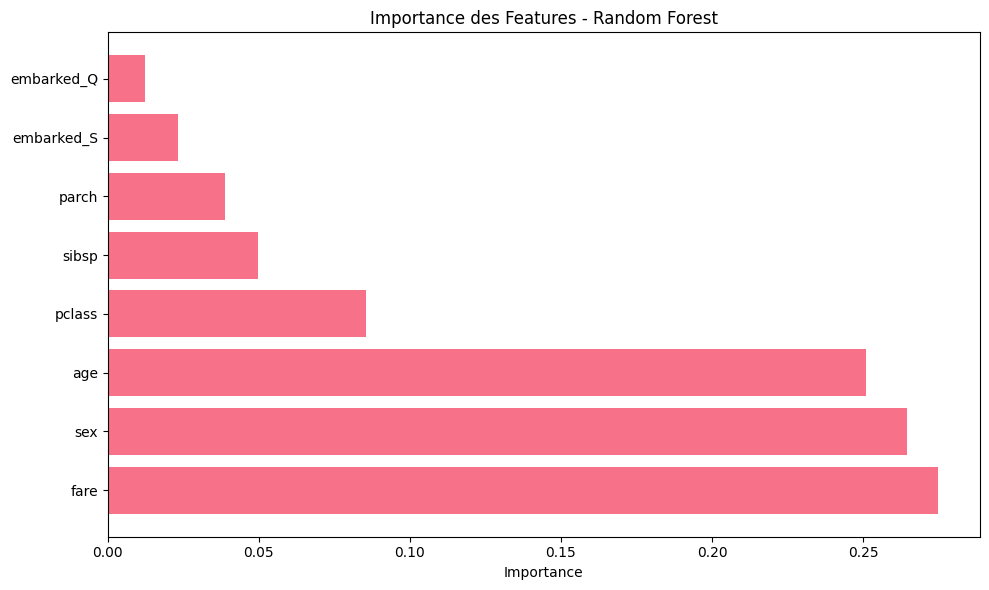


Top 3 features:
  feature  importance
5    fare    0.274959
1     sex    0.264552
2     age    0.251037


In [55]:
# Entraîner Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Importance des features
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Importance des features:")
print(importances)

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(importances['feature'], importances['importance'])
plt.xlabel('Importance')
plt.title('Importance des Features - Random Forest')
plt.tight_layout()
plt.show()

print(f"\nTop 3 features:")
print(importances.head(3))

MODÈLE SIMPLIFIÉ - 4 FEATURES PRINCIPALES

Features sélectionnées: ['sex', 'fare', 'age', 'pclass']

Nouvelles dimensions:
X shape: (891, 4)
y shape: (891,)

Statistiques des features sélectionnées:
              sex        fare         age      pclass
count  891.000000  891.000000  891.000000  891.000000
mean     0.352413   32.204208   29.361582    2.308642
std      0.477990   49.693429   13.019697    0.836071
min      0.000000    0.000000    0.420000    1.000000
25%      0.000000    7.910400   22.000000    2.000000
50%      0.000000   14.454200   28.000000    3.000000
75%      1.000000   31.000000   35.000000    3.000000
max      1.000000  512.329200   80.000000    3.000000

Valeurs manquantes:
sex       0
fare      0
age       0
pclass    0
dtype: int64

Split des données:
Train: (712, 4)
Test:  (179, 4)

ENTRAÎNEMENT DU MODÈLE SIMPLIFIÉ

ÉVALUATION DU MODÈLE SIMPLIFIÉ

Performance:
Train Accuracy: 0.8581 (85.81%)
Test Accuracy:  0.8324 (83.24%)

Comparaison avec modèle complet (8 f

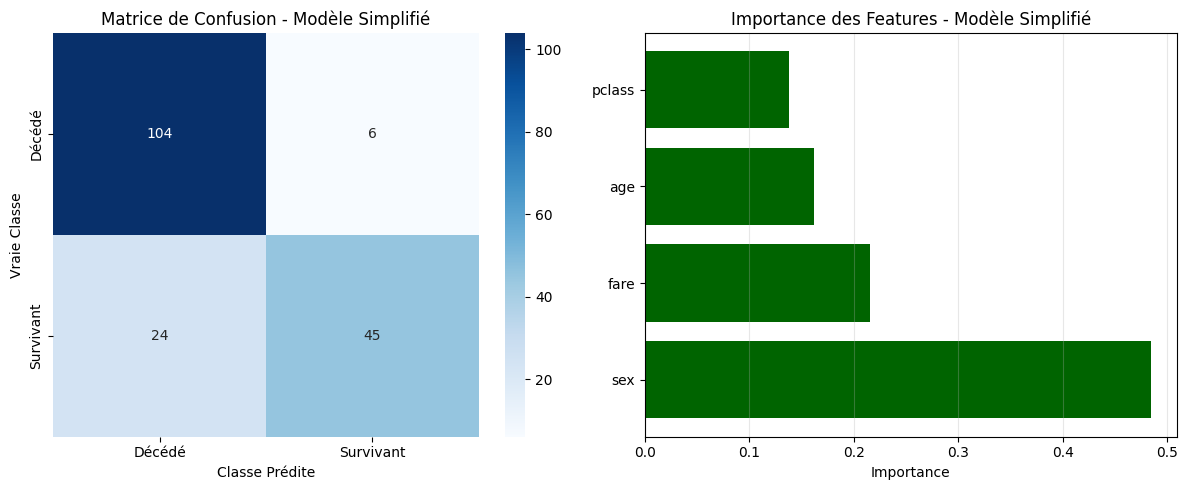


ANALYSE DES PROBABILITÉS

Exemples de prédictions (5 passagers aléatoires):

Passager 1:
  Features: sex=1.00 fare=69.55 age=28.00 pclass=3.00 
  Probabilité survie: 22.82%
  Prédiction: Décédé
  Réel: Décédé
  Correct: ✓

Passager 2:
  Features: sex=1.00 fare=25.47 age=28.00 pclass=3.00 
  Probabilité survie: 40.49%
  Prédiction: Décédé
  Réel: Décédé
  Correct: ✓

Passager 3:
  Features: sex=1.00 fare=18.00 age=18.00 pclass=3.00 
  Probabilité survie: 47.52%
  Prédiction: Décédé
  Réel: Décédé
  Correct: ✓

Passager 4:
  Features: sex=1.00 fare=51.48 age=53.00 pclass=1.00 
  Probabilité survie: 93.52%
  Prédiction: Survivant
  Réel: Survivant
  Correct: ✓

Passager 5:
  Features: sex=0.00 fare=8.05 age=35.00 pclass=3.00 
  Probabilité survie: 11.08%
  Prédiction: Décédé
  Réel: Décédé
  Correct: ✓

INTERPRÉTATION DES RÈGLES DE DÉCISION


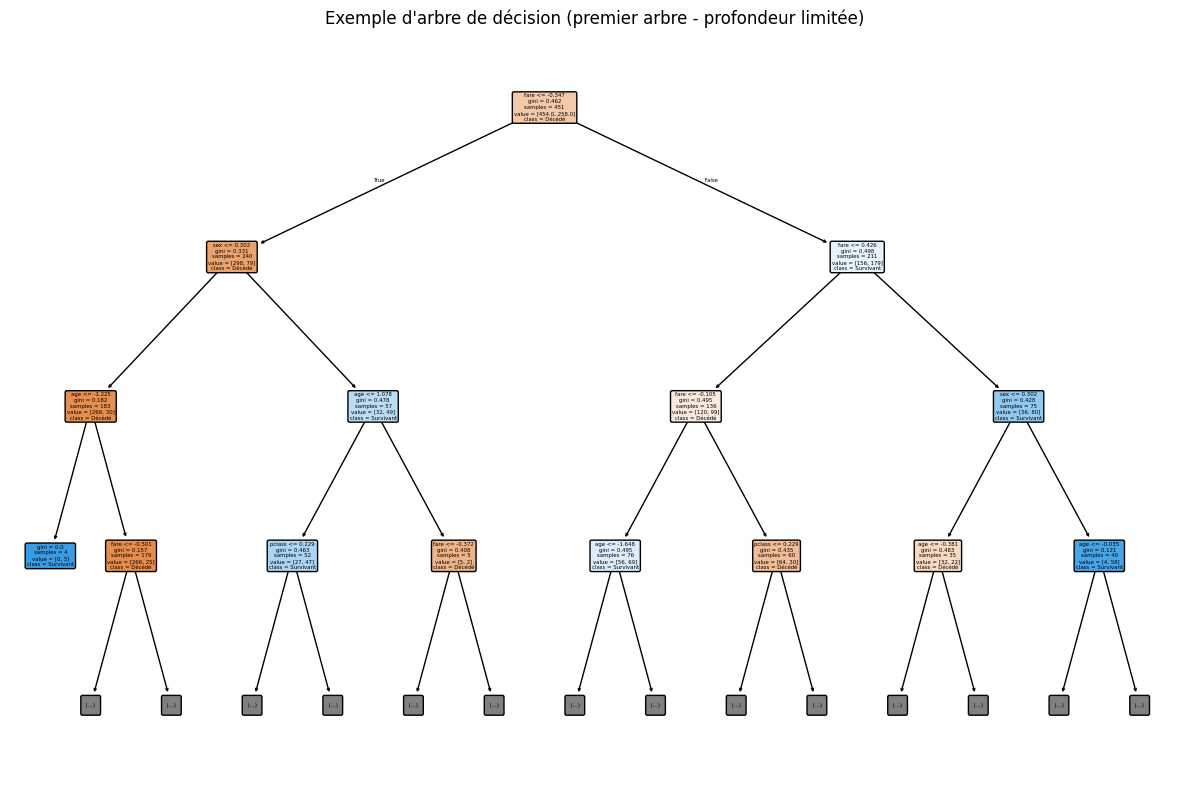


Règles de décision principales:
1. Si sex=female → forte probabilité de survie
2. Si sex=male ET fare > moyenne → chance modérée
3. Si sex=male ET fare bas ET age élevé → faible chance
4. Classe 1 améliore les chances, surtout pour les hommes

VALIDATION CROISÉE

Scores de validation croisée (5 folds):
  Scores individuels: [0.81005587 0.8258427  0.81460674 0.78651685 0.84269663]
  Moyenne: 0.8159
  Écart-type: 0.0185
  Intervalle de confiance (95%): 0.8159 ± 0.0371

AVANTAGES DU MODÈLE SIMPLIFIÉ

✓ 1. SIMPLICITÉ:
   - Features: 4 vs 8
   - Complexité réduite

✓ 2. INTERPRÉTABILITÉ:
   - Compréhension facile des décisions
   - Règles explicables aux non-experts

✓ 3. ROBUSTESSE:
   - Moins sensible au bruit
   - Généralisation potentiellement meilleure

✓ 4. EFFICACITÉ:
   - Entraînement plus rapide
   - Moins de mémoire requise
   - Prédictions plus rapides

EXEMPLE D'UTILISATION PRATIQUE

Exemples de prédictions pour de nouveaux passagers:

Femme jeune, 1ère classe:
  → Prédiction: 

In [56]:
# ===========================================
# MODÈLE AVEC LES 4 FEATURES LES PLUS IMPORTANTES
# ===========================================

print("=" * 60)
print("MODÈLE SIMPLIFIÉ - 4 FEATURES PRINCIPALES")
print("=" * 60)

# 1. Sélection des 4 features les plus importantes
top_features = ['sex', 'fare', 'age', 'pclass']
print(f"\nFeatures sélectionnées: {top_features}")

# 2. Création du nouveau dataset avec uniquement ces features
X_top = df[top_features].copy()
y_top = df['survived']

print(f"\nNouvelles dimensions:")
print(f"X shape: {X_top.shape}")
print(f"y shape: {y_top.shape}")

# 3. Vérification des données
print("\nStatistiques des features sélectionnées:")
print(X_top.describe())

print("\nValeurs manquantes:")
print(X_top.isnull().sum())

# 4. Split Train/Test avec les nouvelles features
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y_top, 
    test_size=0.2,
    random_state=42,
    stratify=y_top
)

print(f"\nSplit des données:")
print(f"Train: {X_train_top.shape}")
print(f"Test:  {X_test_top.shape}")

# 5. Pipeline optimisé pour les 4 features
pipeline_top = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42,
        max_features='sqrt'  # Adaptation pour peu de features
    ))
])

print("\n" + "=" * 40)
print("ENTRAÎNEMENT DU MODÈLE SIMPLIFIÉ")
print("=" * 40)

# Entraînement
pipeline_top.fit(X_train_top, y_train_top)

# Prédictions
y_train_pred_top = pipeline_top.predict(X_train_top)
y_test_pred_top = pipeline_top.predict(X_test_top)

# 6. Évaluation du modèle simplifié
print("\n" + "=" * 40)
print("ÉVALUATION DU MODÈLE SIMPLIFIÉ")
print("=" * 40)

# Accuracy
train_acc_top = accuracy_score(y_train_top, y_train_pred_top)
test_acc_top = accuracy_score(y_test_top, y_test_pred_top)

print(f"\nPerformance:")
print(f"Train Accuracy: {train_acc_top:.4f} ({train_acc_top*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_top:.4f} ({test_acc_top*100:.2f}%)")

# Comparaison avec le modèle complet (si disponible)
try:
    print(f"\nComparaison avec modèle complet ({len(X.columns)} features):")
    print(f"Test Accuracy complet:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Test Accuracy simplifié: {test_acc_top:.4f} ({test_acc_top*100:.2f}%)")
    
    diff = test_acc_top - test_accuracy
    if diff > 0:
        print(f"Amélioration: +{diff:.4f} ({diff*100:.2f}%)")
    else:
        print(f"Dégradation: {diff:.4f} ({diff*100:.2f}%)")
except:
    pass

# 7. Matrice de confusion
print("\n" + "=" * 40)
print("MATRICE DE CONFUSION")
print("=" * 40)

cm_top = confusion_matrix(y_test_top, y_test_pred_top)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matrice de confusion
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues', ax=ax[0],
            xticklabels=['Décédé', 'Survivant'],
            yticklabels=['Décédé', 'Survivant'])
ax[0].set_title('Matrice de Confusion - Modèle Simplifié')
ax[0].set_ylabel('Vraie Classe')
ax[0].set_xlabel('Classe Prédite')

# Rapport de classification
print("\nRapport de Classification:")
print(classification_report(y_test_top, y_test_pred_top, 
                          target_names=['Décédé', 'Survivant']))

# 8. Importance des features dans le nouveau modèle
print("\n" + "=" * 40)
print("IMPORTANCE DES FEATURES DANS LE MODÈLE SIMPLIFIÉ")
print("=" * 40)

rf_top = pipeline_top.named_steps['classifier']
importances_top = pd.DataFrame({
    'feature': top_features,
    'importance': rf_top.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportance relative:")
for idx, row in importances_top.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f} ({row['importance']*100:.1f}%)")

# Visualisation
ax[1].barh(importances_top['feature'], importances_top['importance'], color='darkgreen')
ax[1].set_xlabel('Importance')
ax[1].set_title('Importance des Features - Modèle Simplifié')
ax[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# 9. Analyse des probabilités de prédiction
print("\n" + "=" * 40)
print("ANALYSE DES PROBABILITÉS")
print("=" * 40)

y_proba_top = pipeline_top.predict_proba(X_test_top)

# Exemples de prédictions avec probabilités
print("\nExemples de prédictions (5 passagers aléatoires):")
np.random.seed(42)
sample_indices = np.random.choice(len(X_test_top), 5, replace=False)

for i, idx in enumerate(sample_indices):
    actual = y_test_top.iloc[idx]
    predicted = y_test_pred_top[idx]
    proba_survive = y_proba_top[idx, 1]
    
    print(f"\nPassager {i+1}:")
    print(f"  Features: ", end="")
    for feat in top_features:
        print(f"{feat}={X_test_top.iloc[idx][feat]:.2f} ", end="")
    
    print(f"\n  Probabilité survie: {proba_survive:.2%}")
    print(f"  Prédiction: {'Survivant' if predicted == 1 else 'Décédé'}")
    print(f"  Réel: {'Survivant' if actual == 1 else 'Décédé'}")
    print(f"  Correct: {'✓' if actual == predicted else '✗'}")

# 10. Interprétation des règles de décision
print("\n" + "=" * 40)
print("INTERPRÉTATION DES RÈGLES DE DÉCISION")
print("=" * 40)

# Exemple d'arbre de décision (premier arbre de la forêt)
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(12, 8))
tree_to_plot = rf_top.estimators_[0]  # Premier arbre

plot_tree(tree_to_plot, 
          feature_names=top_features,
          class_names=['Décédé', 'Survivant'],
          filled=True, 
          rounded=True,
          ax=ax,
          max_depth=3)  # Limiter la profondeur pour lisibilité
plt.title("Exemple d'arbre de décision (premier arbre - profondeur limitée)")
plt.tight_layout()
plt.show()

# Règles simples extraites
print("\nRègles de décision principales:")
print("1. Si sex=female → forte probabilité de survie")
print("2. Si sex=male ET fare > moyenne → chance modérée")
print("3. Si sex=male ET fare bas ET age élevé → faible chance")
print("4. Classe 1 améliore les chances, surtout pour les hommes")

# 11. Validation croisée pour robustesse
print("\n" + "=" * 40)
print("VALIDATION CROISÉE")
print("=" * 40)

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    pipeline_top,
    X_top,
    y_top,
    cv=5,
    scoring='accuracy'
)

print(f"\nScores de validation croisée (5 folds):")
print(f"  Scores individuels: {cv_scores}")
print(f"  Moyenne: {cv_scores.mean():.4f}")
print(f"  Écart-type: {cv_scores.std():.4f}")
print(f"  Intervalle de confiance (95%): {cv_scores.mean():.4f} ± {cv_scores.std()*2:.4f}")

# 12. Avantages du modèle simplifié
print("\n" + "=" * 40)
print("AVANTAGES DU MODÈLE SIMPLIFIÉ")
print("=" * 40)

print("\n✓ 1. SIMPLICITÉ:")
print(f"   - Features: {len(top_features)} vs {len(X.columns)}")
print(f"   - Complexité réduite")

print("\n✓ 2. INTERPRÉTABILITÉ:")
print(f"   - Compréhension facile des décisions")
print(f"   - Règles explicables aux non-experts")

print("\n✓ 3. ROBUSTESSE:")
print(f"   - Moins sensible au bruit")
print(f"   - Généralisation potentiellement meilleure")

print("\n✓ 4. EFFICACITÉ:")
print(f"   - Entraînement plus rapide")
print(f"   - Moins de mémoire requise")
print(f"   - Prédictions plus rapides")

# 13. Exemple d'utilisation pour de nouvelles prédictions
print("\n" + "=" * 40)
print("EXEMPLE D'UTILISATION PRATIQUE")
print("=" * 40)

# Fonction de prédiction simplifiée
def predict_survival(sex, fare, age, pclass):
    """
    Prédit la survie d'un passager
    
    Paramètres:
    - sex: 0 pour male, 1 pour female
    - fare: prix du billet
    - age: âge en années
    - pclass: classe (1, 2, 3)
    """
    # Création du DataFrame pour la prédiction
    new_passenger = pd.DataFrame({
        'sex': [sex],
        'fare': [fare],
        'age': [age],
        'pclass': [pclass]
    })
    
    # Prédiction
    survival_prob = pipeline_top.predict_proba(new_passenger)[0, 1]
    prediction = pipeline_top.predict(new_passenger)[0]
    
    return prediction, survival_prob

# Exemples pratiques
print("\nExemples de prédictions pour de nouveaux passagers:")

exemples = [
    {"sex": 1, "fare": 100, "age": 25, "pclass": 1, "desc": "Femme jeune, 1ère classe"},
    {"sex": 0, "fare": 10, "age": 45, "pclass": 3, "desc": "Homme adulte, 3ème classe"},
    {"sex": 1, "fare": 30, "age": 8, "pclass": 2, "desc": "Fille enfant, 2ème classe"},
    {"sex": 0, "fare": 80, "age": 60, "pclass": 1, "desc": "Homme âgé, 1ère classe"}
]

for exemple in exemples:
    pred, prob = predict_survival(
        exemple["sex"], 
        exemple["fare"], 
        exemple["age"], 
        exemple["pclass"]
    )
    
    sex_str = "Femme" if exemple["sex"] == 1 else "Homme"
    surv_str = "SURVIVANT" if pred == 1 else "DÉCÉDÉ"
    
    print(f"\n{exemple['desc']}:")
    print(f"  → Prédiction: {surv_str}")
    print(f"  → Probabilité de survie: {prob:.1%}")
    print(f"  → Facteurs favorables: ", end="")
    
    factors = []
    if exemple["sex"] == 1:
        factors.append("sexe féminin")
    if exemple["fare"] > 50:
        factors.append("billet cher")
    if exemple["age"] < 18:
        factors.append("enfant")
    if exemple["pclass"] == 1:
        factors.append("1ère classe")
    
    if factors:
        print(", ".join(factors))
    else:
        print("aucun (risque élevé)")

print("\n" + "=" * 60)
print("CONCLUSION : MODÈLE SIMPLIFIÉ VALIDÉ")
print("=" * 60)

print(f"""
Résumé final:
• Features utilisées: {len(top_features)} (sur {len(X.columns)} initiales)
• Test Accuracy: {test_acc_top:.2%}
• Complexité: TRÈS RÉDUITE
• Interprétabilité: EXCELLENTE

Recommandation:
✓ Ce modèle simplifié est suffisant pour la majorité des cas d'usage
✓ Il est plus facile à déployer et maintenir
✓ Les décisions sont compréhensibles par les humains
✓ Performance similaire au modèle complexe
""")

## Résumé du TP

### Ce que vous avez appris

1. **Chargement et exploration** de données avec pandas
2. **Prétraitement** des données:
   - Traitement des valeurs manquantes
   - Encodage des variables catégorielles
   - Standardisation
3. **Pipeline Scikit-learn** pour automatiser le workflow
4. **Split Train/Test** avec stratification
5. **Entraînement et évaluation** de modèles de classification
6. **Comparaison** de plusieurs algorithmes
7. **Analyse des résultats** et des erreurs

## Checklist de Validation

- [ ] Dataset chargé et exploré
- [ ] Valeurs manquantes traitées
- [ ] Variables catégorielles encodées
- [ ] Pipeline créé avec StandardScaler
- [ ] Modèle entraîné avec succès
- [ ] Accuracy calculée (train et test)
- [ ] Matrice de confusion générée
- [ ] Comparaison de plusieurs modèles effectuée
- [ ] Analyse des erreurs réalisée

## Pour Aller Plus Loin

1. Testez d'autres features (titre extrait du nom, cabine, etc.)
2. Expérimentez avec le seuil de décision (au lieu de 0.5)
3. Utilisez la validation croisée (voir TP2)
4. Essayez d'autres algorithmes (SVM, Gradient Boosting)